### Logistic回归

#### 1.训练算法：使用梯度上升找到最佳参数
* 数据集：100个样本点，每个点包含两个数值型特征：X1和X2。
* 在此数据集上，通过梯度上升法找到最佳回归系数，也就是logistic回归模型的最佳参数。

In [3]:
from numpy import *

In [4]:
def loadDataSet():
    dataMat = []; labelMat = []
    fr = open('testSet.txt')
    for line in fr.readlines():
        lineArr = line.strip().split()
        # x0=1,x1,x2   x3是标签
        dataMat.append([1.0, float(lineArr[0]), float(lineArr[1])])
        labelMat.append(int(lineArr[2]))
    return dataMat,labelMat

In [5]:
def sigmoid(inX):
    return 1.0/(1+exp(-inX))

* 梯度更新公式(矩阵方式，chuony博客中是计算整个的损失函数形式：weights = weights + alpha * dataMatrix.transpose()* error
* 矩阵形式：https://blog.csdn.net/weixin_44344462/article/details/88989450

In [11]:
def gradAscent(dataMatIn, classLabels):
    dataMatrix = mat(dataMatIn)              # 转换为numpy矩阵数据类型 100*3
    labelMat = mat(classLabels).transpose()  # numpy矩阵转置
    m,n = shape(dataMatrix)
    alpha = 0.001
    maxCycles = 500
    weights = ones((n,1))
    for k in range(maxCycles):              # 迭代次数
        h = sigmoid(dataMatrix*weights)     # 100*3  3*1 = 100*1
        error = (labelMat - h)              # 100*1
        weights = weights + alpha * dataMatrix.transpose()* error  # 3*100 100*1=3*1
    return weights

In [12]:
dataArr,labelMat =loadDataSet()
gradAscent(dataArr,labelMat)

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

#### 2.分析数据：画出决策边界

In [13]:
def plotBestFit(weights):
    import matplotlib.pyplot as plt
    dataMat,labelMat=loadDataSet()
    dataArr = array(dataMat)
    n = shape(dataArr)[0] 
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(n):
        if int(labelMat[i])== 1:
            xcord1.append(dataArr[i,1]); ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1]); ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    x = arange(-3.0, 3.0, 0.1)                   # x是array数组（60，）
    # 这里的y是X2。要画决策边界sigmoid为1/2,0=w0x0+w1x1... 0是两个发类的边界处。
    # X0为1，X1为x
    y = (-weights[0]-weights[1]*x)/weights[2]   # y是array数组（60，）,如果没有getA()是矩阵（1，60）
    ax.plot(x, y)                                # x y必须是同等维度才能画图   
    plt.xlabel('X1'); plt.ylabel('X2');
    plt.show()

In [15]:
weights=gradAscent(dataArr,labelMat)

In [18]:
weights

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

In [17]:
weights.getA()  

array([[ 4.12414349],
       [ 0.48007329],
       [-0.6168482 ]])

* 转换为数组array,不然输入函数会报错。
* numpy 的array和matrix不一样 
* [1,2,3] 维度为(3,) ， [[1,2,3]] 维度为(1,3)

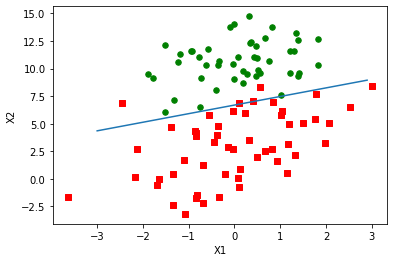

In [27]:
plotBestFit(weights.getA())

#### 3.训练算法：随机梯度上升
* 随机梯度上升算法：一次仅用一个样本点来更新回归系数。
* 由于可以在新样本到来时对分类器进行增量式更新，因而随机梯度上升算法是一个在线学习算法。
* 与“在线学习”相对应，一次处理所有数据被称作是“批处理”。

In [1]:
def stocGradAscent0(dataMatrix, classLabels):
    m,n = shape(dataMatrix)
    alpha = 0.01
    weights = ones(n)
    # 一个一个样本的进行计算，因此是数值
    for i in range(m):
        h = sigmoid(sum(dataMatrix[i]*weights))
        error = classLabels[i] - h
        weights = weights + alpha * error * dataMatrix[i]
    return weights

* 随机梯度上升算法与梯度上升算法在代码上很相似，但也有一些区别：
* 第一，后者的变量h和误差error都是向量，而前者则全是数值；
* 第二，前者没有矩阵的转换过程，所有变量的数据类型都是NumPy数组。

In [7]:
dataArr,labelMat =loadDataSet()
type(dataArr)

list

In [8]:
stocGradAscent0(dataArr,labelMat)  # weights = ones(n)是数组类型

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

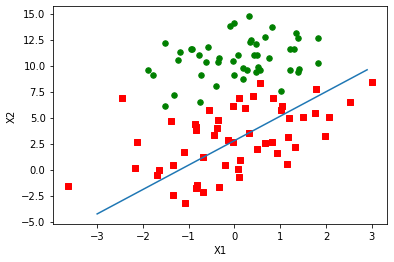

In [15]:
weights = stocGradAscent0(array(dataArr),labelMat)
plotBestFit(weights)   

* 效果并不好，分类器错分了三分之一的样本。原因在于前者迭代了500次，算法收敛到稳定值。
* 随机梯度：要经过大量迭代才能达到稳定值，期间还有一些小的周期性波动。
* 产生这种现象的原因是存在一些不能正确分类的样本点（数据集并非线性可分），在每次迭代时会引发系数的剧烈改变。我们期望算法能避免来回波动，从而收敛到某个值。另外，收敛速度也需要加快。

In [20]:
# 改进的随机梯度上升算法
def stocGradAscent1(dataMatrix, classLabels, numIter=150):
    m,n = shape(dataMatrix)
    weights = ones(n)   
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m):
            alpha = 4/(1.0+j+i)+0.0001     # alpha每次迭代时需要调整
            randIndex = int(random.uniform(0,len(dataIndex))) # 随机选取更新
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            del(dataIndex[randIndex])                        # 再删除再重新选取
    return weights

* 改进1：alpha在每次迭代的时候都会调整，这会缓解数据波动或高频波动
    * 虽然alpha会随着迭代次数不断减小，但永远不会减小到0，这是还存在一个常数项。必须这样做的原因是为了保证在多次迭代之后新数据仍然具有一定的影响。
    * 如果要处理的问题是动态变化的，那么可以适当加大上述常数项，来确保新的值获得更大的回归系数。
    * 在降低alpha的函数中，alpha每次减少1/(j+i) ，其中j是迭代次数，i是样本点的下标。这样当j<<max(i)时，alpha就不是严格下降的。避免参数的严格下降也常
见于模拟退火算法等其他优化算法中。 
* 改进2：通过随机选取样本来更新回归系数，可以减少周期性的波动。

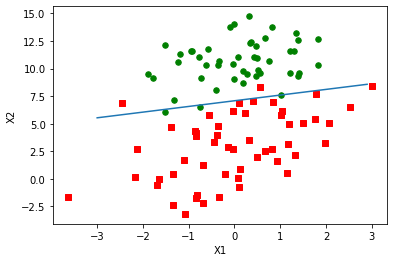

In [21]:
weights = stocGradAscent1(array(dataArr),labelMat)
plotBestFit(weights)

### 例：从疝气病症预测病马的死亡率
* 数据包含368个样本和28个特征，数据集中有30%的值是缺失的。
* 疝病是描述马胃肠痛的术语。然而，这种病不一定源自马的胃肠问题，其他问题也可能引发马疝病。
* 该数据集中包含了医院检测马疝病的一些指标，有的指标比较主观，有的指标难以测量，例如马的疼痛级别。

#### 1.准备数据：处理数据中的缺失值
* 可用方法：
    * 使用可用特征的均值来填补缺失值；
    * 使用特殊值来填补缺失值，如-1；
    * 忽略有缺失值的样本；
    * 使用相似样本的均值添补缺失值； 
    * 使用另外的机器学习算法预测缺失值。

* 预处理阶段要做两件事：第一，所有的缺失值必须用一个实数值来替换，因为我们使用的NumPy数据类型不允许包含缺失值。这里选择实数0来替换所有缺失值，恰好能适用于Logistic回归。这样做的直觉在
于，我们需要的是一个在更新时不会影响系数的值。
    weights = weights + alpha * error * dataMatrix[randIndex]，如果dataMatrix的某特征对应值为0，那么该特征的系数将不做更新，即weights = weights
* 另外，由于sigmoid(0)=0.5，即它对结果的预测不具有任何倾向性，因此上述做法也不会对误差项造成任何影响。
* 基于上述原因，将缺失值用0代替既可以保留现有数据，也不需要对优化算法进行修改。此外，该数据集中的特征取值一般不为0，因此在某种意义上说它也满足“特殊值”这个要求。

* 第二件事：如果在测试数据集中发现了一条数据的类别标签已经缺失，那么我们的简单做法是将该条数据丢弃。这是因为类别标签与特征不同，很难确定采用某个合适的值来替换。采用Logistic回归进行分类时这种做法是合理的，而如果采用类似kNN的方法就可能不太可行。

* 原始的数据集经过预处理之后保存成两个文件：horseColicTest.txt和horseColicTraining.txt。
* 数据最初有三个类别标签，分别代表马的三种情况：“仍存活”、“已经死亡”和“已经安乐死”。这里为了方便，将“已经死亡”和“已经安乐死”合并成“未能存活”这个标签 。

#### 2.测试算法：用 Logistic 回归进行分类

In [23]:
def classifyVector(inX, weights):
    prob = sigmoid(sum(inX*weights))
    if prob > 0.5: return 1.0
    else: return 0.0

In [24]:
def colicTest():
    frTrain = open('horseColicTraining.txt'); frTest = open('horseColicTest.txt')
    trainingSet = []; trainingLabels = []
    for line in frTrain.readlines():
        currLine = line.strip().split('\t')
        lineArr =[]
        for i in range(21):
            lineArr.append(float(currLine[i]))
        trainingSet.append(lineArr)
        trainingLabels.append(float(currLine[21]))
    trainWeights = stocGradAscent1(array(trainingSet), trainingLabels, 1000)
    errorCount = 0; numTestVec = 0.0
    for line in frTest.readlines():
        numTestVec += 1.0
        currLine = line.strip().split('\t')
        lineArr =[]
        for i in range(21):
            lineArr.append(float(currLine[i]))
        if int(classifyVector(array(lineArr), trainWeights))!= int(currLine[21]):
            errorCount += 1
    errorRate = (float(errorCount)/numTestVec)
    print ("the error rate of this test is: %f" % errorRate)
    return errorRate

In [25]:
# 调用函数colicTest()10次并求结果的平均值。
def multiTest():
    numTests = 10; errorSum=0.0
    for k in range(numTests):
        errorSum += colicTest()
    print ("after %d iterations the average error rate is: %f" % (numTests, errorSum/float(numTests)))

In [27]:
multiTest()

C:\Users\Lenovo\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


the error rate of this test is: 0.373134
the error rate of this test is: 0.313433
the error rate of this test is: 0.402985
the error rate of this test is: 0.268657
the error rate of this test is: 0.283582
the error rate of this test is: 0.343284
the error rate of this test is: 0.402985
the error rate of this test is: 0.388060
the error rate of this test is: 0.313433
the error rate of this test is: 0.447761
after 10 iterations the average error rate is: 0.353731


* 调整colicTest()中的迭代次数和stochGradAscent1()中的步长，平均错误率还可以下降。

### 总结：
* Logistic回归的目的是寻找一个非线性函数Sigmoid的最佳拟合参数，求解过程可以由最优化算法来完成。常用的是梯度上升算法。
* 随机梯度上升算法与梯度上升算法的效果相当，但占用更少的计算资源。此外，随机梯度上升是一个在线算法，它可以在新数据到来时就完成参数更新，而不需要重新读取整个数据集来进行批处理运算。
* 机器学习的一个重要问题就是如何处理缺失数据。这个问题没有标准答案，取决于实际应用中的需求。现有一些解决方案，每种方案都各有优缺点。